In [2]:
library(Seurat)

Warning message:
“package ‘Seurat’ was built under R version 4.2.3”
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [3]:
sce = readRDS('./after_rename.rds')

In [4]:
macro = readRDS('./myeloid.rds')

In [5]:
Idents(macro) = 'seurat_clusters'

In [6]:
mac = subset(macro,idents = c(1,3,4,5,6,7,8))

In [7]:
sce@meta.data$celltype2 = ifelse(rownames(sce@meta.data) %in% rownames(mac@meta.data), 'Macrophages',sce$celltype )

In [8]:
Idents(sce) ='celltype2'

In [9]:
Idents(macro) = 'celltype'

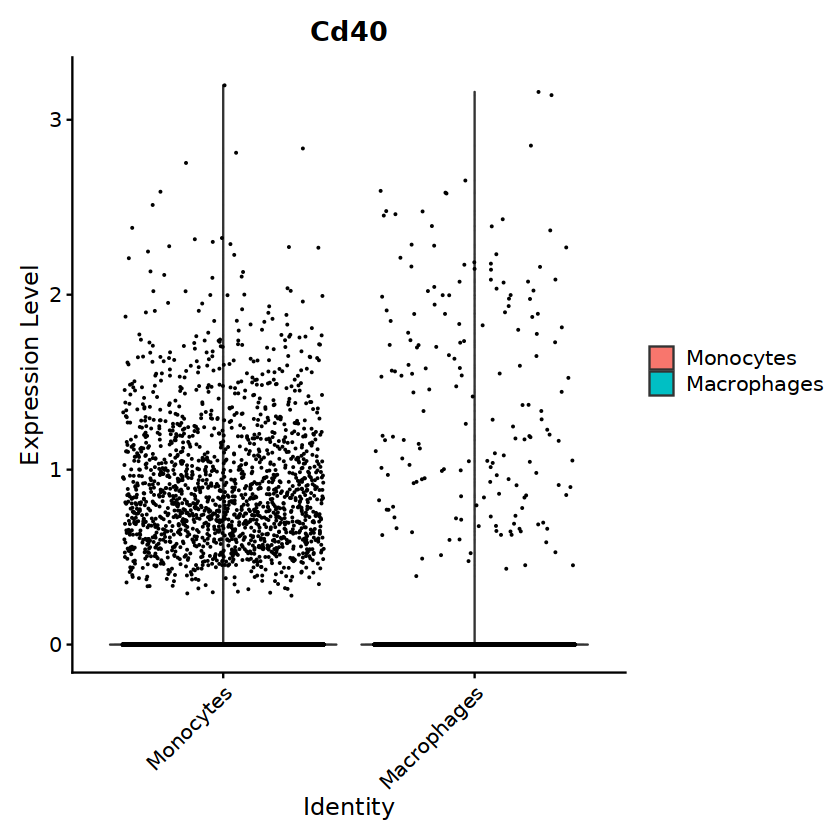

In [10]:
VlnPlot(macro,features = 'Cd40')

In [11]:
Idents(macro) = 'seurat_clusters'

In [12]:
label = c('mono1','Ccr2+','mono2','Ccr2+','Ccr2+','Ccr2+','Ccr2+','Ccr2-','Ccr2+')

In [13]:
celltype =  data.frame(ClusterID=c(0:8), celltype=label, stringsAsFactors = FALSE)

In [14]:
macro@meta.data$celltype = "NA"
# 赋值
for(i in 1:nrow(celltype)){
  macro@meta.data[which(macro@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]}

In [15]:
Idents(macro) = 'celltype'

In [16]:
DefaultAssay(macro) = 'RNA'

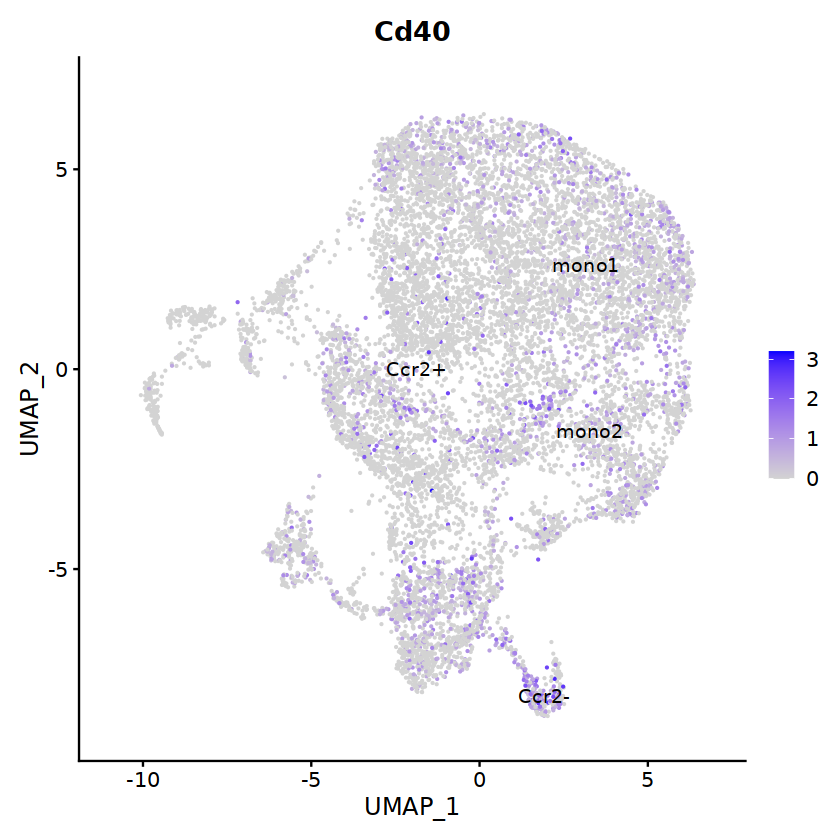

In [17]:
FeaturePlot(macro,features = 'Cd40',label = T)

In [18]:
mye  = macro

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in read.table("./te.txt", header = T):
“incomplete final line found by readTableHeader on './te.txt'”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Joining with `by = join_by(gene)`
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


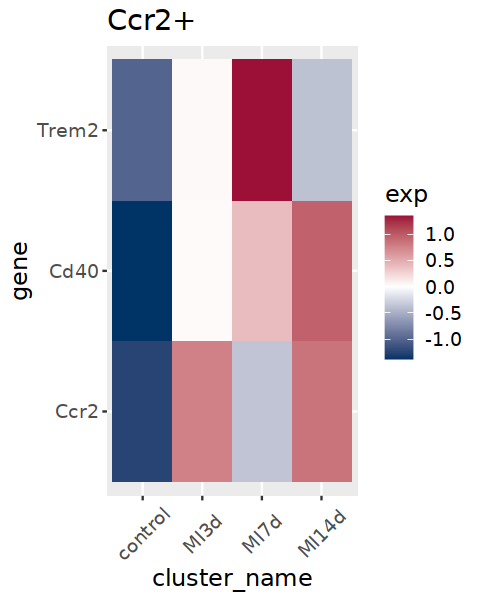

In [19]:
Idents(mye) = 'celltype'
c3 = subset(mye, idents= 'Ccr2+')

library(dplyr)

gene = read.table('./te.txt',header =T)

Idents(c3) ='orig.ident'

df <- as.data.frame(AverageExpression(object = c3)$RNA)
library(tidyr)
df %>%
    filter(row.names(.) %in% gene$gene) %>% 
    apply(., 1, function(y) (y - mean(y)) / sd(y) ^ as.logical(sd(y))) %>% 
          t() -> df2
df2 %>% as.data.frame() %>% 
    tibble::rownames_to_column(var = "gene")%>%
    right_join(gene) %>%
    pivot_longer(cols = `control`:`MI7d`, names_to = "cluster_name", values_to = "exp")%>%
    group_by(gene) %>%
    mutate(exp = as.numeric(scale(exp))) %>%
    dplyr::ungroup() -> df3

cluster_name <- c("control",'MI3d','MI7d','MI14d')

library(ggplot2)
options(repr.plot.height = 5,repr.plot.width = 4)
df3 %>% ggplot(aes(x = cluster_name,
               y = gene,
               fill = exp)) +
    geom_tile() +
    scale_fill_gradient2(low="#003366", high="#990033", mid="white") +
    scale_x_discrete(limits = cluster_name) +
  theme(axis.text.x =element_text(angle =45,hjust =0.5,vjust = 0.5))+ 
          theme(text = element_text(size = 14))+ggtitle('Ccr2+')

In [20]:
library(harmony)

Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.2.3”


In [21]:
immune.combined = macro

In [22]:
immune.combined <-NormalizeData(immune.combined) %>% FindVariableFeatures()
immune.combined<-ScaleData(immune.combined,feature=rownames(immune.combined)) %>% RunPCA(verbose = FALSE) %>% RunHarmony( group.by.vars = "orig.ident")
immune.combined<-RunUMAP(immune.combined, reduction = "harmony", dims = 1:20)
immune.combined<-RunTSNE(immune.combined, reduction = "harmony", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "harmony", dims = 1:20) %>% FindClusters()

Centering and scaling data matrix

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:14:16 UMAP embedding parameters a = 0.9922 b = 1.112

12:14:16 Read 11477 rows and found 20 numeric columns

12:14:16 Using Annoy for neighbor search, n_neighbors = 30

12:14:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|-

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 11477
Number of edges: 381947

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8405
Number of communities: 18
Elapsed time: 1 seconds


In [23]:
options(repr.plot.height = 8,repr.plot.width = 8)

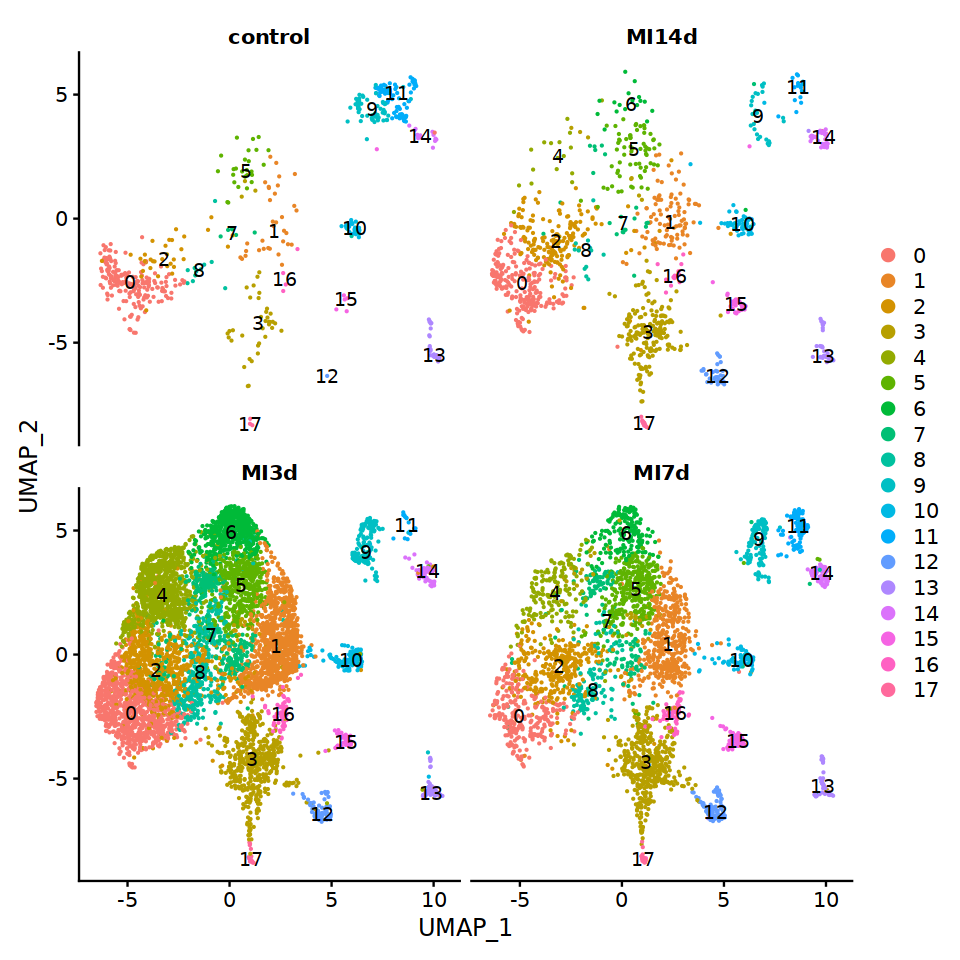

In [24]:
DimPlot(immune.combined, reduction = "umap", split.by = "orig.ident",ncol = 2,label = T)

In [25]:
options(repr.plot.height = 5,repr.plot.width = 12)

In [28]:
Idents(macro) = 'seurat_clusters'

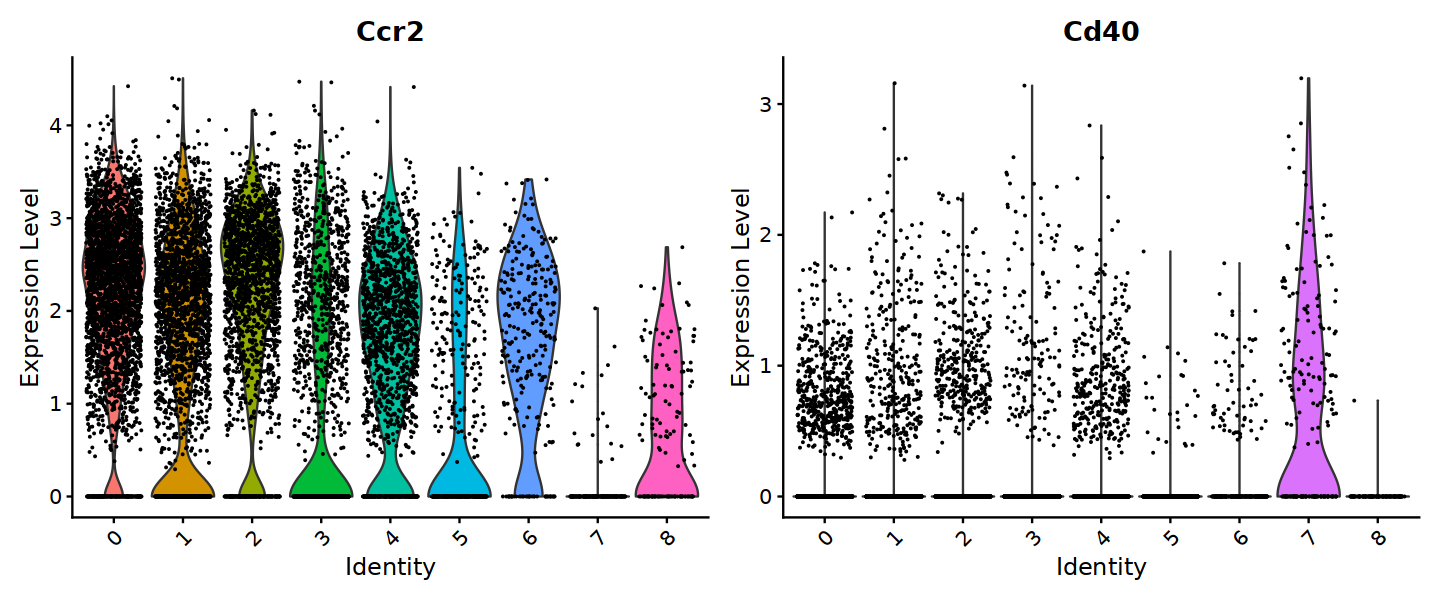

In [29]:
VlnPlot(macro,features = c('Ccr2','Cd40'))

In [30]:
table(macro$orig.ident)


control   MI14d    MI3d    MI7d 
    576    1088    6617    3196 

In [34]:
for ( i in unique(macro$orig.ident)){
    Idents(macro) = 'orig.ident'
    new.data = subset(macro,idents = i)
    Idents(new.data) = 'seurat_clusters'
    VlnPlot(new.data,features = c('Ccr2','Cd40'))
    ggsave(file = paste0('./out/',i,'.pdf'))
    
}

Saving 6.67 x 6.67 in image
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [53]:
Idents(immune.combined) = 'orig.ident'

table(immune.combined$seurat_clusters,Idents(immune.combined))

    
     control MI14d MI3d MI7d
  0      195   229  904  262
  1       33    99  999  425
  2       34   186  828  351
  3       39   187  526  498
  4        0    17  965  183
  5       26    66  460  355
  6        0    18  578  181
  7        5    23  378  146
  8       12    13  379  128
  9       58    26  153  121
  10      30    50  118   79
  11      85    16   14  103
  12       1    32   72   99
  13      29    35   65   44
  14      16    31   59   66
  15       6    34   42   77
  16       4    13   62   55
  17       3    13   15   23